# Library

## Imports

In [1]:
from typing import Optional

from transformers.models.esm.openfold_utils.protein import from_prediction
!pip install kagglehub

In [29]:
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
import math
from typing import Optional 

## Plotting library

Plotting of outliers and quantiles for a feature  

In [3]:
def plot_box_plots(data):
    # Checking amount of features and forming plot field
    num_features = len(data.columns)
    plt.figure(figsize=(15, num_features * 3))

    # For every feature plot quantiles with rectangle and rest part as outliers
    for i, feature in enumerate(data.columns, 1):
        plt.subplot(num_features, 1, i)
        sns.boxplot(x=data[feature])
        plt.title(f'Box plot for {feature}')
        plt.gca().set_xlim(data[feature].min() - 1, data[feature].max() + 1)

    # Print
    plt.tight_layout()
    plt.show()

Plot the correlation heatmap

In [4]:
def plot_correlation_matrix(df, method='spearman'):
    # Calculate correlation matrix
    corr_matrix = df.corr(method=method)

    # Create a heatmap to visualize the correlation matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar=True, square=True)
    plt.title(f'Correlation Heatmap ({method})')
    plt.show()

## Distribution library

This class help to analyse distributions of the features.

It provides **2** methods:
- for plotting numerical feature's distribution
- for plotting frequency for nominal value

In [5]:
class DistributionAnalyser:
    def __init__(self, df):
        self._df = df.copy()

    # The function that plots numerical features distribution
    def plot_numerical_distributions(self, numerical_features, num_columns=2):
        # Calculate the number of numerical features in the dataset
        num_features = len(numerical_features)

        # Determine the number of rows needed to arrange the subplots in a grid
        num_rows = math.ceil(num_features / num_columns)

        # Set the figure size dynamically based on the number of rows
        plt.figure(figsize=(15, (num_rows + 1) * 5))

        # Loop through each numerical feature to create a histogram
        for i, feature in enumerate(numerical_features):
            # Define the subplot position in the grid
            plt.subplot(num_rows, num_columns, i + 1)

            # Plot the histogram for the current numerical feature
            sns.histplot(self._df[feature], bins=30, kde=False)

            # Set labels and title for the plot
            plt.xlabel('Value')
            plt.ylabel('Frequency')
            plt.title(feature)

        # Adjust the layout to prevent overlapping plots
        plt.tight_layout()

        # Display the figure with all subplots
        plt.show()

    # The function that plots categorical features relation frequency
    def plot_categorical_relation_frequency(self, categorical_features, num_columns=2, top_n=100, height=5):
        # Calculate the number of categorical features in the dataset
        num_features = len(categorical_features)

        # Determine the number of rows needed for the grid layout
        num_rows = math.ceil(num_features / num_columns)

        # Set the figure size dynamically based on the number of rows and specified height
        plt.figure(figsize=(15, num_rows * height))

        # Loop through each categorical feature to create bar plots
        for i, feature in enumerate(categorical_features):
            # Define the subplot position in the grid
            plt.subplot(num_rows, num_columns, i + 1)

            # Check if the column contains list-like entries (e.g., lists or sets) and explode if necessary
            if self._df[feature].apply(lambda x: isinstance(x, list)).any():
                current_values = self._df.explode(feature)[feature].dropna()
            else:
                current_values = self._df[feature].dropna()

            # Calculate the relative frequency of the top_n most frequent categories
            current_values = current_values.value_counts().head(top_n) / len(self._df[feature])

            # Plot the bar chart for the categorical feature
            sns.barplot(x=current_values.values, y=current_values.index, palette='viridis')

            # Set labels and title for better interpretability
            plt.xlabel('Frequency')
            plt.ylabel('Value')
            plt.title(f'Distribution of {feature}')

            # Rotate y-axis labels if there are many categories or long category names
            if len(current_values) > 10 or any(len(str(label)) > 15 for label in current_values.index):
                plt.yticks(rotation=0)

        # Adjust layout to prevent overlapping elements
        plt.tight_layout()

        # Display the figure with all subplots
        plt.show()

## Missing values library

This class is used for two purposes:
- draw a heatmap of missing values in the datasets' features
- show matrix between **features / number of values**

In [6]:
class NanAnalyser:
    def __init__(self, df):
        self._df = df.copy()

    def plot_nan_values_heatmap(self):
        """
        Generate a heatmap to visualize missing values in the dataframe.

        - Uses a seaborn heatmap where missing values are highlighted.
        - The heatmap helps in identifying patterns of missing data.
        """
        sns.heatmap(self._df.isnull(), cbar=False, cmap="viridis")
        plt.title("Missing Values Heatmap")
        plt.show()

    def get_nan_statistic(self) -> pd.DataFrame:
        """
        Calculate and return statistics about missing values in the dataframe.

        - Computes the count and percentage of missing values for each column.
        - Filters out columns with no missing values.
        - Returns a summary as a DataFrame.
        """
        # Calculate the count of missing values for each column
        missing_count = self._df.isnull().sum()

        # Calculate the percentage of missing values relative to the total number of rows
        missing_percentage = (missing_count / len(self._df)) * 100

        # Filter out columns that do not have missing values
        missing_data = missing_count[missing_count > 0]
        missing_data_percentage = missing_percentage[missing_percentage > 0]

        # Create a summary DataFrame with missing values statistics
        missing_summary = pd.DataFrame({
            'Missing Values Count': missing_data,
            'Missing Values Percentage': missing_data_percentage
        })

        return missing_summary

## Time series library

This class helps to create **time series**

In [38]:
class TimeSeriesGenerator:
    def __init__(self, df: pd.DataFrame):
        self._df = df

    def plot_time_series(self, date_col: str, target_col: str, group_col: Optional[str]):
        """
        Plots the time series data with separate lines for each group.
        :param date_col: Name of the date column
        :param target_col: Name of the target feature column
        :param group_col: Name of the column for grouping
        """
        grouped_data = self._create_time_series(date_col, target_col, group_col)
        plt.figure(figsize=(10, 5))
        
        if group_col:
            for group in grouped_data[group_col].unique():
                subset = grouped_data[grouped_data[group_col] == group]
                plt.plot(subset[date_col], subset[target_col], label=f'Group {group}')
                
            plt.title(f"Time series by group {group_col}")
        
        plt.xlabel(date_col)
        plt.ylabel(f"Avg {target_col}")
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def _create_time_series(self, date_col: str, target_col: str, group_col: str) -> pd.DataFrame:
        """
        Creates a time series by aggregating data based on the specified grouping column and calculating the average target column value.
        :param date_col: Name of the date column
        :param target_col: Name of the target feature column
        :param group_col: Name of the column for grouping
        :return: pandas DataFrame with the time series
        """
        self._df[date_col] = pd.to_datetime(self._df[date_col])
        grouped = (self._df.groupby([date_col, group_col])[target_col]
                   .mean()
                   .reset_index())
        return grouped

# Datasets loading and filtering 

## Reasoning of the datasets' choice 

The following datasets were chosen to explore and use for **SVD++** since they have information either about the relationships between users and businesses (this information is the purpose of the RecSys to restore) or about some features of users or items itself (such as business dataset):
- business dataset;
- tip dataset
- review

User dataset contains only information that is related to user, but not to U-I relations as well as checkin dataset that contain potential feature only for business.

Normally datasets are downloaded from the Kaggle, but in the purpose of time-saving the local path placed instead.
If you want to download the datasets again, just uncomment the code below.

In [8]:
path = "/Users/simon/.cache/kagglehub/datasets/yelp-dataset/yelp-dataset/versions/4"

# path = kagglehub.dataset_download("yelp-dataset/yelp-dataset")
# 
# print("Path to dataset files:", path)

Business' features description:
- `business_id` - id of a business
- `name` - name of the business
- `address` - address of the business (geographical data)
- `city` - city of the business (geographical data)
- `state` - state of the business (geographical data)
- `postal_code` - postal code of the business (geographical data)
- `latitude` - latitude of the business (geographical data)
- `longitude` - longitude of the business (geographical data)
- `review_count` - the amount of the reviews gathered for the particular business
- `is_open` - is the business opened (closed businesses are not relevant to use)
- `attributes` - business' attributes (no provided context)
- `categories` - categories related to the business
- `hours` - working hours

In [9]:
business_df = pd.read_json(f"{path}/yelp_academic_dataset_business.json", lines=True)
business_df

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150341,IUQopTMmYQG-qRtBk-8QnA,Binh's Nails,3388 Gateway Blvd,Edmonton,AB,T6J 5H2,53.468419,-113.492054,3.0,13,1,"{'ByAppointmentOnly': 'False', 'RestaurantsPri...","Nail Salons, Beauty & Spas","{'Monday': '10:0-19:30', 'Tuesday': '10:0-19:3..."
150342,c8GjPIOTGVmIemT7j5_SyQ,Wild Birds Unlimited,2813 Bransford Ave,Nashville,TN,37204,36.115118,-86.766925,4.0,5,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Pets, Nurseries & Gardening, Pet Stores, Hobby...","{'Monday': '9:30-17:30', 'Tuesday': '9:30-17:3..."
150343,_QAMST-NrQobXduilWEqSw,Claire's Boutique,"6020 E 82nd St, Ste 46",Indianapolis,IN,46250,39.908707,-86.065088,3.5,8,1,"{'RestaurantsPriceRange2': '1', 'BusinessAccep...","Shopping, Jewelry, Piercing, Toy Stores, Beaut...",None
150344,mtGm22y5c2UHNXDFAjaPNw,Cyclery & Fitness Center,2472 Troy Rd,Edwardsville,IL,62025,38.782351,-89.950558,4.0,24,1,"{'BusinessParking': '{'garage': False, 'street...","Fitness/Exercise Equipment, Eyewear & Optician...","{'Monday': '9:0-20:0', 'Tuesday': '9:0-20:0', ..."


Reasons of feature dropping:
- geographical data doesn't make any sense since we don't have the same type of information about the user
- there are features that don't describe anything in the purpose of RecSys (i.e. `name` or `hours`)
- `attributes` feature doesn't have a context to analyze it

Features that remains:
- `business_id` - id of a business
- `review_count` - this feature can potentially participate in the forming of **implicit rating**
- `categories` - this feature can potentially participate in the forming of **implicit rating** + it's necessary to separate it into different entity
- `is_open` - it's necessary to check ratio between open / closed businesses and filter them based on this feature since the recommendation of the closed business doesn't make any sense

In [10]:
filtered_business_id = business_df[['business_id', 'review_count', 'is_open', 'categories']]
filtered_business_id

,business_id,review_count,is_open,categories
0,Pns2l4eNsfO8kk83dixA6A,7,0,"Doctors, Traditional Chinese Medicine, Naturop..."
1,mpf3x-BjTdTEA3yCZrAYPw,15,1,"Shipping Centers, Local Services, Notaries, Ma..."
2,tUFrWirKiKi_TAnsVWINQQ,22,0,"Department Stores, Shopping, Fashion, Home & G..."
3,MTSW4McQd7CbVtyjqoe9mw,80,1,"Restaurants, Food, Bubble Tea, Coffee & Tea, B..."
4,mWMc6_wTdE0EUBKIGXDVfA,13,1,"Brewpubs, Breweries, Food"
...,...,...,...,...
150341,IUQopTMmYQG-qRtBk-8QnA,13,1,"Nail Salons, Beauty & Spas"
150342,c8GjPIOTGVmIemT7j5_SyQ,5,1,"Pets, Nurseries & Gardening, Pet Stores, Hobby..."
150343,_QAMST-NrQobXduilWEqSw,8,1,"Shopping, Jewelry, Piercing, Toy Stores, Beaut..."
150344,mtGm22y5c2UHNXDFAjaPNw,24,1,"Fitness/Exercise Equipment, Eyewear & Optician..."


Reviews' features:
- `review_id` | `user_id` | `business_id` - id of the review and foreign keys (one user can leave several reviews for one item)
- `stars` - **explicit rating** provided by user for the particular item in the particular moment
- `useful` | `funny` | `cool`  - user's flags about (presumably) review. We don't drop this feature since it's necessary to get any evidences that theory about the nature of the feature is right
- `text` - the content of review (can be useful for potential sentimental analysis)
- `date` - the timestamp of review

All the features can be used for the future development and need to be analysed.

In [11]:
review_df = pd.read_json(f"{path}/yelp_academic_dataset_review.json", lines=True)
review_df

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15
...,...,...,...,...,...,...,...,...,...
6990275,H0RIamZu0B0Ei0P4aeh3sQ,qskILQ3k0I_qcCMI-k6_QQ,jals67o91gcrD4DC81Vk6w,5,1,2,1,Latest addition to services from ICCU is Apple...,2014-12-17 21:45:20
6990276,shTPgbgdwTHSuU67mGCmZQ,Zo0th2m8Ez4gLSbHftiQvg,2vLksaMmSEcGbjI5gywpZA,5,2,1,2,"This spot offers a great, affordable east week...",2021-03-31 16:55:10
6990277,YNfNhgZlaaCO5Q_YJR4rEw,mm6E4FbCMwJmb7kPDZ5v2Q,R1khUUxidqfaJmcpmGd4aw,4,1,0,0,This Home Depot won me over when I needed to g...,2019-12-30 03:56:30
6990278,i-I4ZOhoX70Nw5H0FwrQUA,YwAMC-jvZ1fvEUum6QkEkw,Rr9kKArrMhSLVE9a53q-aA,5,1,0,0,For when I'm feeling like ignoring my calorie-...,2022-01-19 18:59:27


Tip's features:
- `user_id` | `business_id` - ids of users and businesses with uncertainty in uniqueness of them and their pairs
- `text` - content of tip (can be useful for potential sentimental analysis)
- `date` - the date of publication
- `compliment_count` - how many users complimented a particular tip

In [12]:
tip_df = pd.read_json(f"{path}/yelp_academic_dataset_tip.json", lines=True)
tip_df

,user_id,business_id,text,date,compliment_count
0,AGNUgVwnZUey3gcPCJ76iw,3uLgwr0qeCNMjKenHJwPGQ,Avengers time with the ladies.,2012-05-18 02:17:21,0
1,NBN4MgHP9D3cw--SnauTkA,QoezRbYQncpRqyrLH6Iqjg,They have lots of good deserts and tasty cuban...,2013-02-05 18:35:10,0
2,-copOvldyKh1qr-vzkDEvw,MYoRNLb5chwjQe3c_k37Gg,It's open even when you think it isn't,2013-08-18 00:56:08,0
3,FjMQVZjSqY8syIO-53KFKw,hV-bABTK-glh5wj31ps_Jw,Very decent fried chicken,2017-06-27 23:05:38,0
4,ld0AperBXk1h6UbqmM80zw,_uN0OudeJ3Zl_tf6nxg5ww,Appetizers.. platter special for lunch,2012-10-06 19:43:09,0
...,...,...,...,...,...
908910,eYodOTF8pkqKPzHkcxZs-Q,3lHTewuKFt5IImbXJoFeDQ,Disappointed in one of your managers.,2021-09-11 19:18:57,0
908911,1uxtQAuJ2T5Xwa_wp7kUnA,OaGf0Dp56ARhQwIDT90w_g,Great food and service.,2021-10-30 11:54:36,0
908912,v48Spe6WEpqehsF2xQADpg,hYnMeAO77RGyTtIzUSKYzQ,Love their Cubans!!,2021-11-05 13:18:56,0
908913,ckqKGM2hl7I9Chp5IpAhkw,s2eyoTuJrcP7I_XyjdhUHQ,Great pizza great price,2021-11-20 16:11:44,0


The only feature was dropped - `compliment_count` because of the following reason: this feature describes **user-to-user** relationships and would be useful if we've wanted to recommend *users to other users*. But the purpose of the RecSys under development is recommending **items to user**

In [13]:
filtered_tip_df = tip_df.drop(axis=1, columns=['compliment_count'])
filtered_tip_df

,user_id,business_id,text,date
0,AGNUgVwnZUey3gcPCJ76iw,3uLgwr0qeCNMjKenHJwPGQ,Avengers time with the ladies.,2012-05-18 02:17:21
1,NBN4MgHP9D3cw--SnauTkA,QoezRbYQncpRqyrLH6Iqjg,They have lots of good deserts and tasty cuban...,2013-02-05 18:35:10
2,-copOvldyKh1qr-vzkDEvw,MYoRNLb5chwjQe3c_k37Gg,It's open even when you think it isn't,2013-08-18 00:56:08
3,FjMQVZjSqY8syIO-53KFKw,hV-bABTK-glh5wj31ps_Jw,Very decent fried chicken,2017-06-27 23:05:38
4,ld0AperBXk1h6UbqmM80zw,_uN0OudeJ3Zl_tf6nxg5ww,Appetizers.. platter special for lunch,2012-10-06 19:43:09
...,...,...,...,...
908910,eYodOTF8pkqKPzHkcxZs-Q,3lHTewuKFt5IImbXJoFeDQ,Disappointed in one of your managers.,2021-09-11 19:18:57
908911,1uxtQAuJ2T5Xwa_wp7kUnA,OaGf0Dp56ARhQwIDT90w_g,Great food and service.,2021-10-30 11:54:36
908912,v48Spe6WEpqehsF2xQADpg,hYnMeAO77RGyTtIzUSKYzQ,Love their Cubans!!,2021-11-05 13:18:56
908913,ckqKGM2hl7I9Chp5IpAhkw,s2eyoTuJrcP7I_XyjdhUHQ,Great pizza great price,2021-11-20 16:11:44


# EDA

## Reviews dataset

### Basic descriptive statistic

In [14]:
review_df = review_df.set_index('business_id')
review_df

,review_id,user_id,stars,useful,funny,cool,text,date
business_id,,,,,,,,
XQfwVwDr-v0ZS3_CbbE5Xw,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
7ATYjTIgM3jUlt4UM3IypQ,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
YjUWPpI6HXG530lwP-fb2A,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
kxX2SOes4o-D3ZQBkiMRfA,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
e4Vwtrqf-wpJfwesgvdgxQ,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15
...,...,...,...,...,...,...,...,...
jals67o91gcrD4DC81Vk6w,H0RIamZu0B0Ei0P4aeh3sQ,qskILQ3k0I_qcCMI-k6_QQ,5,1,2,1,Latest addition to services from ICCU is Apple...,2014-12-17 21:45:20
2vLksaMmSEcGbjI5gywpZA,shTPgbgdwTHSuU67mGCmZQ,Zo0th2m8Ez4gLSbHftiQvg,5,2,1,2,"This spot offers a great, affordable east week...",2021-03-31 16:55:10
R1khUUxidqfaJmcpmGd4aw,YNfNhgZlaaCO5Q_YJR4rEw,mm6E4FbCMwJmb7kPDZ5v2Q,4,1,0,0,This Home Depot won me over when I needed to g...,2019-12-30 03:56:30


The conclusions from the descriptive statistics:
- All the features have the same amount of items so **there is no Nans** (need to recheck)
- At least `cool` and `funny` (probably `useful` also) have a lot of outliers (checking 75-quantile). At the same time, the max value is dramatically big. This is a relative evidence for the theory about these features are given from different users and describes **user-to-user interaction**
- Following the previous point, described features are candidates for dropping, but it's necessary to recheck amount of outliers, because it's possible that they can be useful for implicit ratings. 
- Time range of the data goes from **2005** until **2022** which let us to assume that we've enough historical data that give us the opportunity to create **time series** and **implicit ratings** based on the history data

In [15]:
review_df.describe()

,stars,useful,funny,cool,date
count,6.990280e+06,6.990280e+06,6.990280e+06,6.990280e+06,6990280
mean,3.748584e+00,1.184609e+00,3.265596e-01,4.986175e-01,2017-01-11 11:22:33.441780992
min,1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,2005-02-16 03:23:22
25%,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2015-01-25 04:53:50.249999872
50%,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2017-06-03 01:26:07
75%,5.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2019-05-23 00:02:46.249999872
max,5.000000e+00,1.182000e+03,7.920000e+02,4.040000e+02,2022-01-19 19:48:45
std,1.478705e+00,3.253767e+00,1.688729e+00,2.172460e+00,NaN


All the features that will be explored are **continuous** (**numerical**)

In [16]:
review_df.dtypes

review_id            object
user_id              object
stars                 int64
useful                int64
funny                 int64
cool                  int64
text                 object
date         datetime64[ns]
dtype: object

Remove text from analyzed feature since for the sentiment analyses it's necessary to provide different analysis for such **type of data**

In [17]:
FEATURES_FOR_ANALYSIS = ['stars', 'useful', 'funny', 'cool', 'date']

### Nan analysis

As it's possible to mention below, **assumption was proved** - there is no Nans in dataset at all

In [18]:
nan_analyser = NanAnalyser(review_df)

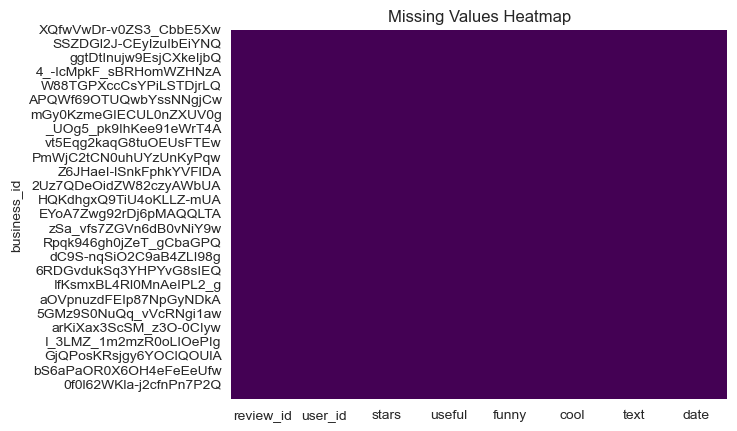

In [19]:
nan_analyser.plot_nan_values_heatmap()

In [20]:
nan_analyser.get_nan_statistic()

,Missing Values Count,Missing Values Percentage


### Distribution and outliers analysis

In [21]:
distribution_analyser = DistributionAnalyser(review_df)

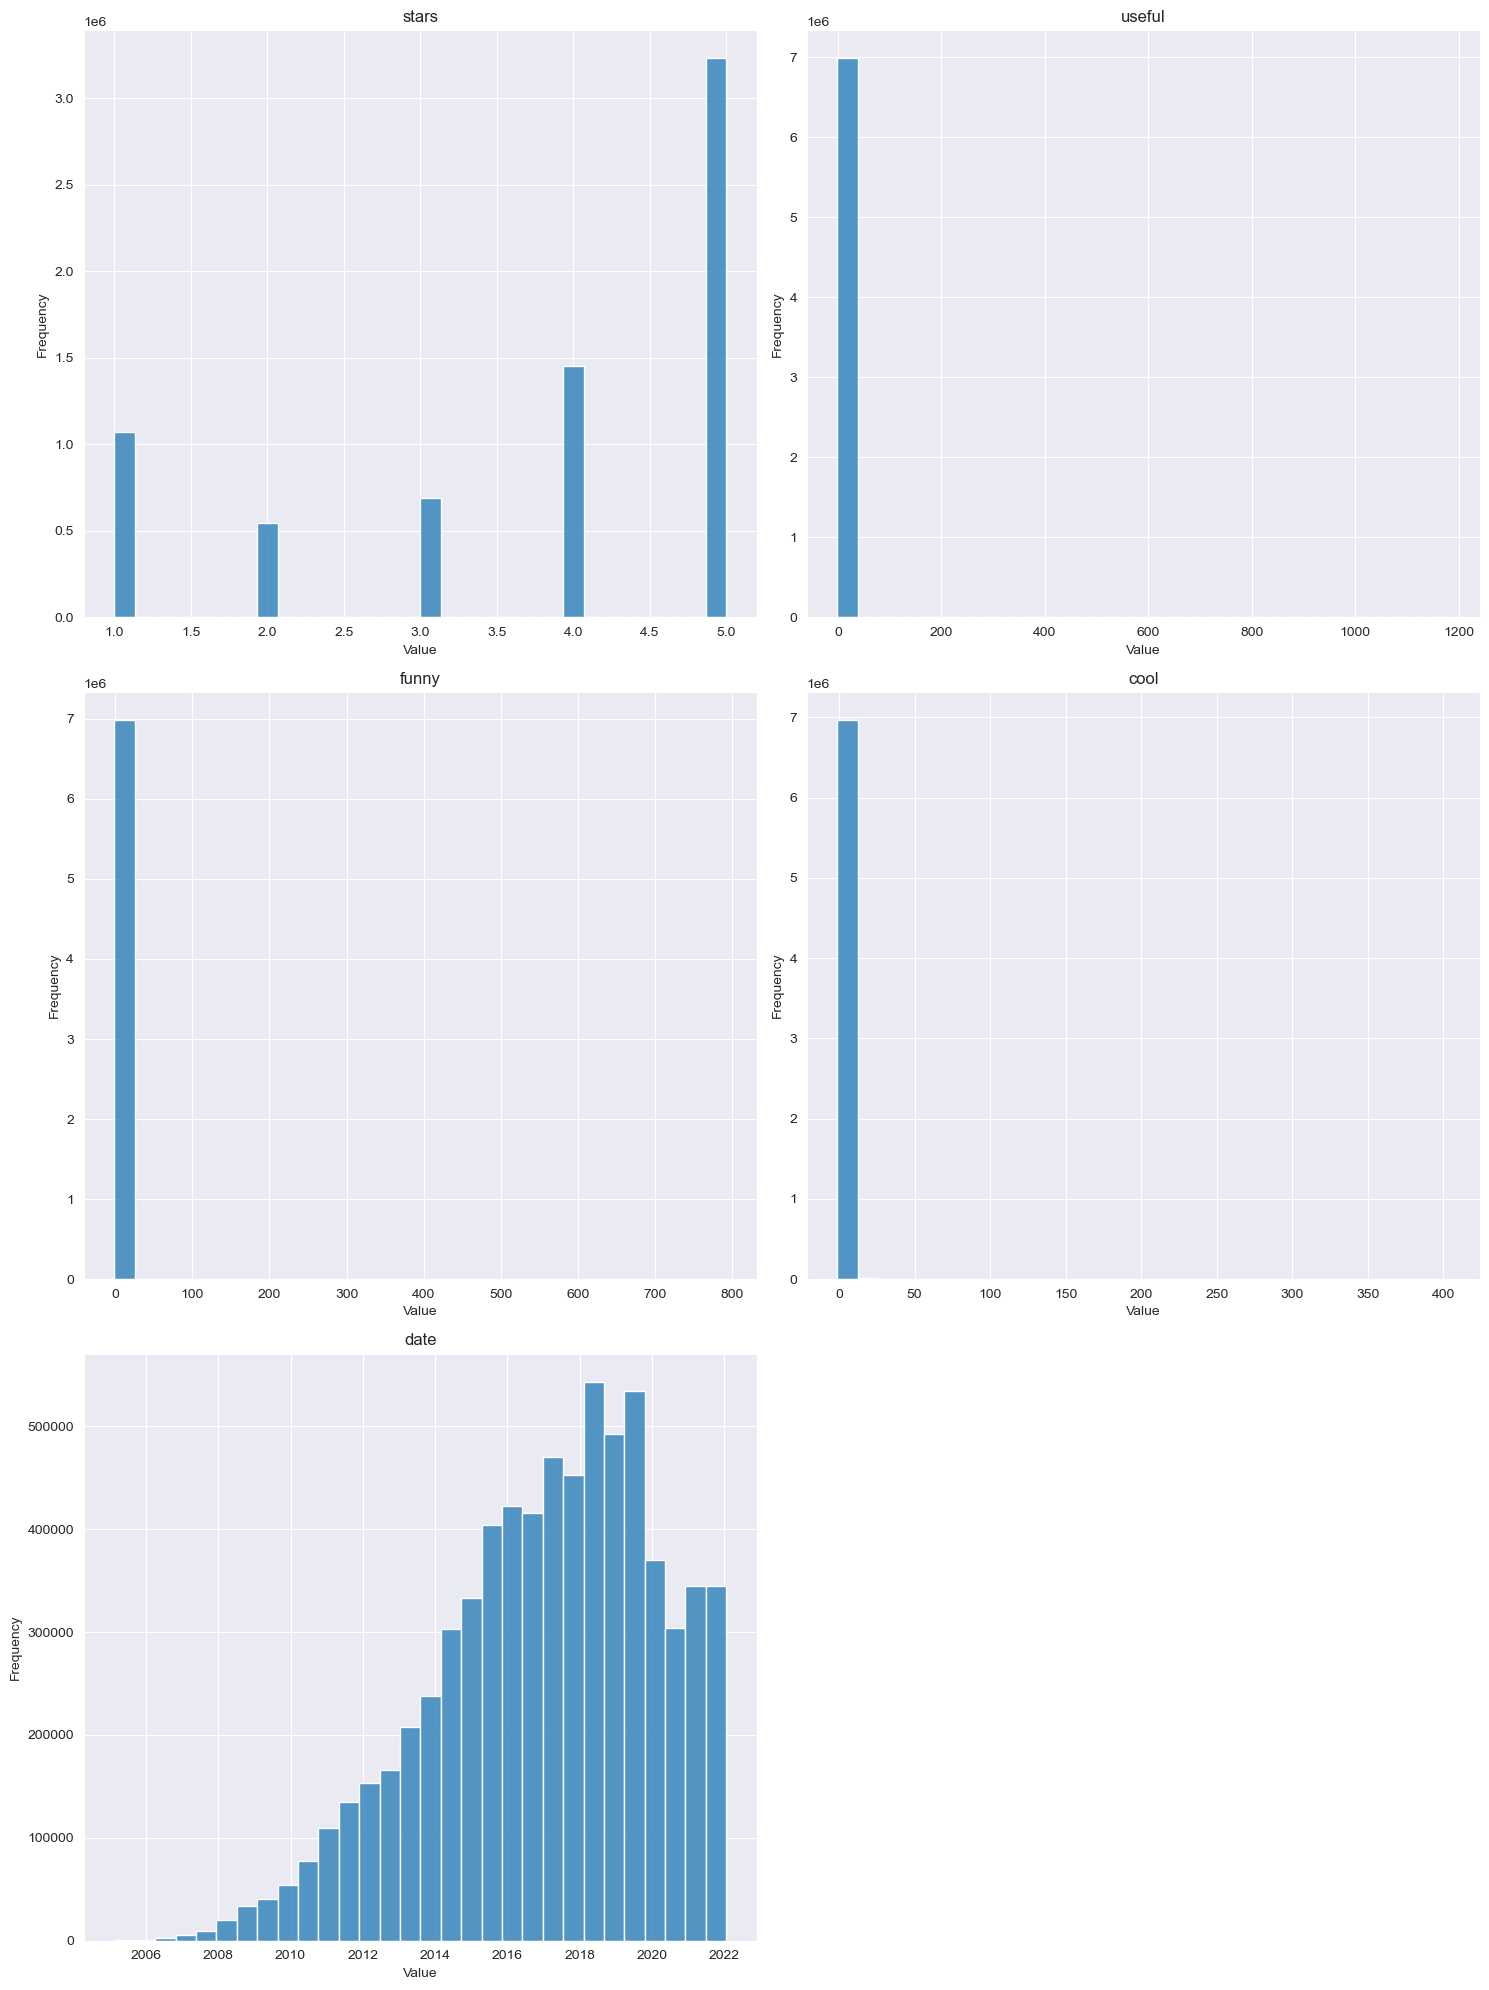

In [22]:
distribution_analyser.plot_numerical_distributions(FEATURES_FOR_ANALYSIS)

In [23]:
# plot_box_plots(review_df)

### Correlation analysis

Extract numerical features

In [24]:
NUMERICAL_FEATURES = ['stars', 'useful', 'funny', 'cool']

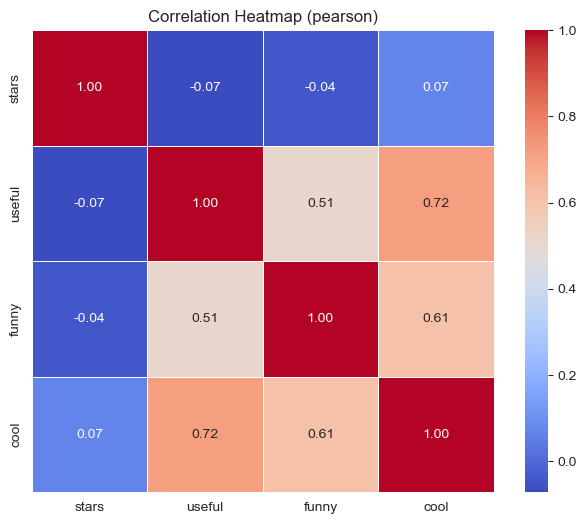

In [25]:
plot_correlation_matrix(review_df[NUMERICAL_FEATURES], method='pearson')

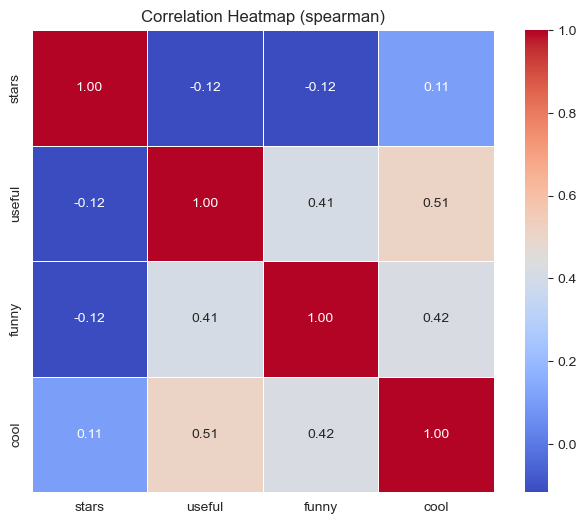

In [26]:
plot_correlation_matrix(review_df[NUMERICAL_FEATURES])

### Time series analysis

In [ ]:
time_series = TimeSeriesGenerator(review_df)

time_series.plot_time_series(date_col='date', target_col='stars', group_col='business_id')

### Conclusions